This notebook creates a very simple deep learning model as a first approach to solve captcha image to text problem <br/>


The model performs a <b>multi-label & multi-class classification</b> <br/>
It has <b>5 softmax output layers</b> (each of them classifies one alphanumeric character of the captcha images) <br/>
To compute the loss function, categorical cross-entropy is used for each output layer and the results are averaged <br/>
The input layer has a tensor of size nx50x200x1 where n is the batch size <br/>
<b>Convolutional, pooling, batch normalization, dropout and dense</b> layers are used to define the inner topology of the network

## Import statements

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *

import keras
import keras.backend as K
from keras.layers import *
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import *
from sklearn.model_selection import train_test_split
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline

Using TensorFlow backend.


## Load the preprocessed data

In [2]:
data = np.load('processed-data.npz')

In [3]:
X, y = data['X'], data['y']

In [4]:
X.shape

(1070, 50, 200, 1)

In [5]:
y.shape

(1070, 5, 36)

In [6]:
np.count_nonzero(y[:, 0, :]) == y.shape[0]

True

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=13)

In [8]:
X_train.shape, X_test.shape

((909, 50, 200, 1), (161, 50, 200, 1))

In [9]:
y_train.shape, y_test.shape

((909, 5, 36), (161, 5, 36))

## Build the model

In [10]:
K.clear_session()

t_in = Input(shape=(50, 200, 1))

def outputs():
    for k in range(0, 5):
        left_crop = floor(k * 25)
        right_crop = max(100 - left_crop, 0)
        t_crop = Cropping2D(((0, 0), (left_crop, right_crop)))(t_in)
        
        t_conv = Conv2D(32, kernel_size=(3, 3), activation='relu')(t_crop)
        t_pool = MaxPool2D((2, 2))(t_conv)
        t_drop = Dropout(0.25)(t_pool)
        
        t_conv2 = Conv2D(16, kernel_size=(3, 3), activation='relu')(t_drop)
        t_pool2 = MaxPool2D((2, 2))(t_conv2)
        t_drop2 = Dropout(0.25)(t_pool2)
        
        t_conv3 = Conv2D(16, kernel_size=(3, 3), activation='relu')(t_drop2)
        t_pool3 = MaxPool2D((2, 2))(t_pool2)
        t_drop3 = Dropout(0.25)(t_pool3)
        
        
        t_flatten = Flatten()(t_drop3)
        t_dense = Dense(64, activation='relu')(t_flatten)
        t_soft = Dense(36, activation='softmax', name='char_{}'.format(k))(t_dense)
        yield t_soft
    
t_out = list(outputs())

In [11]:
model = Model(inputs=[t_in], outputs=t_out)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 200, 1)   0                                            
__________________________________________________________________________________________________
cropping2d_1 (Cropping2D)       (None, 50, 100, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
cropping2d_2 (Cropping2D)       (None, 50, 100, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
cropping2d_3 (Cropping2D)       (None, 50, 100, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
cropping2d

Now we compile the model

In [52]:
model.compile(optimizer=RMSprop(), loss=['categorical_crossentropy'] * 5)

In [53]:
out = model.predict(X[0:1, :, :, 0].reshape([1, 50, 200, 1]))
len(out), out[0].shape

(5, (1, 36))

## Train the model

In [54]:
history = model.fit(X_train, [y_train[:, k, :] for k in range(0, 5)],
                    epochs=5, batch_size=2, verbose=True,
                    callbacks=[])

Epoch 1/5
909/909 [==============================] - 69s 76ms/step - loss: 17.4504 - char_0_loss: 3.5780 - char_1_loss: 3.0807 - char_2_loss: 3.5833 - char_3_loss: 3.6096 - char_4_loss: 3.5988
Epoch 2/5
909/909 [==============================] - 65s 71ms/step - loss: 16.4398 - char_0_loss: 3.3430 - char_1_loss: 2.9644 - char_2_loss: 3.3664 - char_3_loss: 3.3574 - char_4_loss: 3.4086
Epoch 3/5
909/909 [==============================] - 65s 71ms/step - loss: 15.8135 - char_0_loss: 3.2215 - char_1_loss: 2.9509 - char_2_loss: 3.2314 - char_3_loss: 3.2082 - char_4_loss: 3.2015
Epoch 4/5
909/909 [==============================] - 65s 72ms/step - loss: 15.4279 - char_0_loss: 3.1168 - char_1_loss: 2.9430 - char_2_loss: 3.1172 - char_3_loss: 3.1433 - char_4_loss: 3.1076
Epoch 5/5
909/909 [==============================] - 65s 72ms/step - loss: 15.1564 - char_0_loss: 3.0633 - char_1_loss: 2.9412 - char_2_loss: 3.0527 - char_3_loss: 3.0539 - char_4_loss: 3.0452


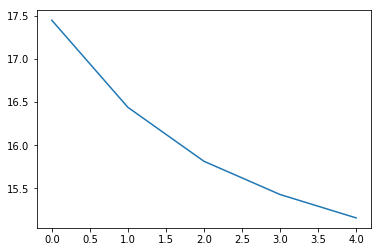

In [55]:
plt.plot(history.history['loss'])

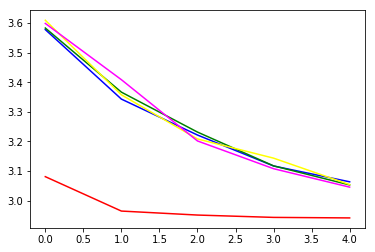

In [56]:
plt.plot(history.history['char_0_loss'], color='blue')
plt.plot(history.history['char_1_loss'], color='red')
plt.plot(history.history['char_2_loss'], color='green')
plt.plot(history.history['char_3_loss'], color='yellow')
plt.plot(history.history['char_4_loss'], color='magenta')

## Evaluate the model

In [20]:
y_test_pred_labels = np.stack(model.predict(X_test)).swapaxes(0, 1).argmax(axis=2)

In [21]:
y_test_pred_labels.shape

(161, 5)

In [22]:
y_test_pred_labels[0,:]

array([13, 13, 13, 13, 29])

In [23]:
y_test_labels = y_test.argmax(axis=2)

In [24]:
y_test_labels[0,:]

array([12, 23, 34,  1,  1])

For each prediction, we calculate a score that will be proportional to the number of characters matched with the captcha text correctly <br/>
The global score will be an average of such values

In [25]:
np.mean(np.mean(y_test_pred_labels == y_test_labels, axis=1))

0.08944099378881987

Also we can calculate the number of predictions that fully matches with the captcha texts and divide it by the number of predictions

In [26]:
np.mean(np.all(y_test_pred_labels == y_test_labels, axis=1))

0.0

This model doesnt solve our classification problem very good